In [1]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate

---

We sample a tile catalog for a single image from `LensingPrior`:

In [2]:
os.chdir('/home/twhit/bliss/case_studies/weak_lensing/')

# Compose lensing_config.yaml
with initialize(config_path="../../", version_base=None):
    cfg = compose("lensing_config",
                  overrides = {"prior.batch_size=1",
                               "prior.n_tiles_h=1",
                               "prior.n_tiles_w=1",
                               "prior.max_sources=200",
                               "prior.constant_shear=0.2",
                               "prior.constant_convergence=0.2",
                               "generate.tiles_to_crop=0"})

In [3]:
prior = instantiate(cfg.prior)

In [4]:
tile_catalog = prior.sample()

And we generate the image with `LensingDecoder`, which calls `GalSim.lens()`:

In [5]:
decoder = instantiate(cfg.decoder)

In [6]:
image1, psf_params = decoder.render_images(tile_catalog)

ttc = cfg.generate.tiles_to_crop
ptc = ttc * decoder.tile_slen  # pixels to crop
if ptc > 0:
    image1 = image1[:, :, ptc:-ptc, ptc:-ptc]

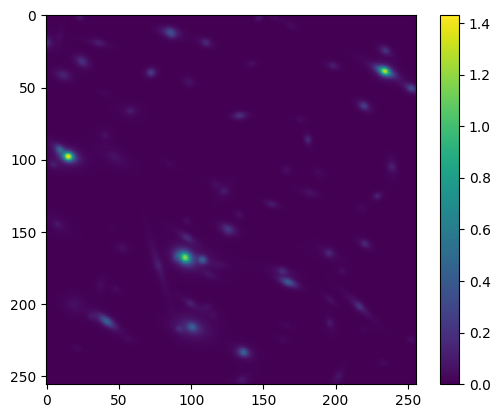

In [7]:
band = 2
_ = plt.imshow((image1[0,band] - image1[0,band].min() + 1).log())
_ = plt.colorbar()

---

Now we'll try to do the same thing manually. We'll manually apply shear and convergence to intrinsic galaxy shapes, and then pass the resulting lensed galaxies into `bliss.decoder.Decoder` (which doesn't call `GalSim.lens()`).

Here are all the latent r.v.s in the tile catalog:

In [8]:
sorted(tile_catalog.keys())

['convergence',
 'fluxes',
 'galaxy_a_b',
 'galaxy_a_d',
 'galaxy_beta_radians',
 'galaxy_bulge_q',
 'galaxy_disk_frac',
 'galaxy_disk_q',
 'locs',
 'n_sources',
 'shear',
 'source_type']

Each galaxy is modeled as a disk plus a bulge. For each of the two profiles, the following relationships hold:

$$
\begin{aligned}
\text{unlensed axis ratio } q_u &= \frac{a_u}{b_u} \\
\text{unlensed ellipticity } e_u &= \frac{1 - q_u}{1 + q_u} \\
\text{unlensed half-light radius } \text{hlr}_u &= \sqrt{a_u \cdot b_u}
\end{aligned}
$$

All of these quantities are affected by shear and convergence in the weak lensing regime. First, note that
$$e_u = \vert \tilde{e}_u \vert = \sqrt{e_{1u}^2 + e_{2u}^2}$$
where
\begin{aligned}
\tilde{e}_u &= e_{1u} + i e_{2u} \\
e_{1u} &= e_u \cos(2\beta) \\
e_{2u} &= e_u \sin(2\beta).
\end{aligned}

Also,
$$
\text{reduced shear } g = \frac{\tilde{\gamma}}{1 - \kappa},
$$
where 
\begin{aligned}
\text{complex shear } \tilde{\gamma} &= \gamma_1 + i \gamma_2 \\
\gamma &= \vert \tilde{\gamma} \vert = \sqrt{\gamma_1^2 + \gamma_2^2}.
\end{aligned}
Let $g^*$ denote the complex conjugate of $g$.

We also have
$$
\text{magnification } \mu = \frac{1}{\sqrt{(1 - \kappa)^2 - (\gamma_1^2 + \gamma_2^2)}}.
$$

Now,

$$
\tilde{e}_\ell = \frac{\tilde{e}_u + g}{1 + g^* \cdot \tilde{e}_u},
$$

and all the formulas that held for unlensed ellipticity also apply here, i.e.,
\begin{aligned}
\text{lensed ellipticity } e_\ell &= \vert \tilde{e}_\ell \vert = \sqrt{e_{1\ell}^2 + e_{2\ell}^2} \\
\tilde{e}_\ell &= e_{1\ell} + i e_{2\ell} \\
e_{1\ell} &= e_\ell \cos(2\beta) \\
e_{2\ell} &= e_\ell \sin(2\beta)
\end{aligned}

We can also derive the lensed axis lengths, axis ratio, and half-light radius. We have
$$
e_\ell = \frac{1 - q_\ell}{1 + q_\ell} \quad \therefore \quad q_\ell = \frac{1 - e_\ell}{1 + e_\ell},
$$

and also
$$
\text{hlr}_\ell = \text{hlr}_u \sqrt{\mu} \quad \text{ (see Buchanan 2023)}
$$

and since $b_\ell = q_\ell a_\ell$, we have
\begin{aligned}
\therefore\quad \sqrt{a_\ell \cdot b_\ell} &= \sqrt{a_u \cdot b_u} \sqrt{\mu} \\
\therefore\quad a_\ell (q_\ell a_\ell) &= a_u (q_u a_u) \mu \\
\therefore\quad q_\ell a_\ell^2 &= q_u a_u^2 \mu \\
\therefore\quad a_\ell &= a_u \sqrt{\frac{q_u \mu}{q_\ell}}.
\end{aligned}

So basically, if we sample $a_u$, $\beta$, $q_u$, $\gamma_1$, $\gamma_2$, and $\kappa$ from the prior, we can then compute

- $e_u$
- $e_{1u}$ and $e_{2u}$
- $\tilde{e}_u$
- $\tilde{\gamma}$
- $g$
- $\mu$
- $\tilde{e}_\ell$
- $e_\ell$
- $q_\ell$
- $a_\ell$
- $b_\ell$

and pass $a_\ell$, $b_\ell$, and $q_\ell$ into the decoder without needing to change its current functionality.

We'll perform the above calculations for the disk:

In [9]:
galaxy_disk_e = (1 - tile_catalog['galaxy_disk_q']) / (1 + tile_catalog['galaxy_disk_q'])
galaxy_disk_e1 = galaxy_disk_e * torch.cos(2 * tile_catalog['galaxy_beta_radians'])
galaxy_disk_e2 = galaxy_disk_e * torch.sin(2 * tile_catalog['galaxy_beta_radians'])
galaxy_disk_complex_e = galaxy_disk_e1 + galaxy_disk_e2 * 1j

In [10]:
shear1 = tile_catalog['shear'][...,0].unsqueeze(-1)
shear2 = tile_catalog['shear'][...,1].unsqueeze(-1)
convergence = tile_catalog['convergence']

complex_shear = shear1 + shear2 * 1j
reduced_shear = complex_shear / (1.0 - convergence)
magnification = 1 / ((1 - convergence)**2 - shear1**2 - shear2**2)

In [11]:
galaxy_disk_complex_e_lensed = (
    (galaxy_disk_complex_e + reduced_shear) / (1.0 + reduced_shear.conj() * galaxy_disk_complex_e)
)
galaxy_disk_e_lensed = galaxy_disk_complex_e_lensed.absolute()

In [12]:
galaxy_disk_e1_lensed = torch.view_as_real(galaxy_disk_complex_e_lensed)[...,0]
galaxy_disk_e2_lensed = torch.view_as_real(galaxy_disk_complex_e_lensed)[...,1]

In [13]:
galaxy_disk_q_lensed = (1 - galaxy_disk_e_lensed) / (1 + galaxy_disk_e_lensed)

In [14]:
galaxy_disk_a_lensed = tile_catalog['galaxy_a_d'] * (
    tile_catalog['galaxy_disk_q'] * magnification / galaxy_disk_q_lensed
).sqrt()

In [15]:
galaxy_disk_b_lensed = galaxy_disk_a_lensed * galaxy_disk_q_lensed

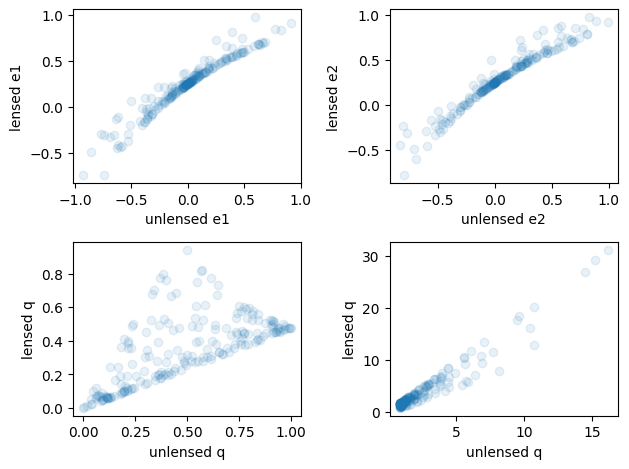

In [16]:
fig, ax = plt.subplots(2, 2)
_ = ax[0,0].scatter(galaxy_disk_e1, galaxy_disk_e1_lensed, alpha = 0.1)
_ = ax[0,0].set_xlabel('unlensed e1')
_ = ax[0,0].set_ylabel('lensed e1')
_ = ax[0,1].scatter(galaxy_disk_e2, galaxy_disk_e2_lensed, alpha = 0.1)
_ = ax[0,1].set_xlabel('unlensed e2')
_ = ax[0,1].set_ylabel('lensed e2')
_ = ax[1,0].scatter(tile_catalog['galaxy_disk_q'], galaxy_disk_q_lensed, alpha = 0.1)
_ = ax[1,0].set_xlabel('unlensed q')
_ = ax[1,0].set_ylabel('lensed q')
_ = ax[1,1].scatter(tile_catalog['galaxy_a_d'], galaxy_disk_a_lensed, alpha = 0.1)
_ = ax[1,1].set_xlabel('unlensed q')
_ = ax[1,1].set_ylabel('lensed q')
fig.tight_layout()

We repeat the above calculations for the bulge:

In [17]:
galaxy_bulge_e = (1 - tile_catalog['galaxy_bulge_q']) / (1 + tile_catalog['galaxy_bulge_q'])
galaxy_bulge_e1 = galaxy_bulge_e * torch.cos(2 * tile_catalog['galaxy_beta_radians'])
galaxy_bulge_e2 = galaxy_bulge_e * torch.sin(2 * tile_catalog['galaxy_beta_radians'])
galaxy_bulge_complex_e = galaxy_bulge_e1 + galaxy_bulge_e2 * 1j

galaxy_bulge_complex_e_lensed = (
    (galaxy_bulge_complex_e + reduced_shear) / (1.0 + reduced_shear.conj() * galaxy_bulge_complex_e)
)
galaxy_bulge_e_lensed = galaxy_bulge_complex_e_lensed.absolute()

galaxy_bulge_e1_lensed = torch.view_as_real(galaxy_bulge_complex_e_lensed)[...,0]
galaxy_bulge_e2_lensed = torch.view_as_real(galaxy_bulge_complex_e_lensed)[...,1]

galaxy_bulge_q_lensed = (1 - galaxy_bulge_e_lensed) / (1 + galaxy_bulge_e_lensed)

galaxy_bulge_a_lensed = tile_catalog['galaxy_a_b'] * (
    tile_catalog['galaxy_bulge_q'] * magnification / galaxy_bulge_q_lensed
).sqrt()

galaxy_bulge_b_lensed = galaxy_bulge_a_lensed * galaxy_bulge_q_lensed

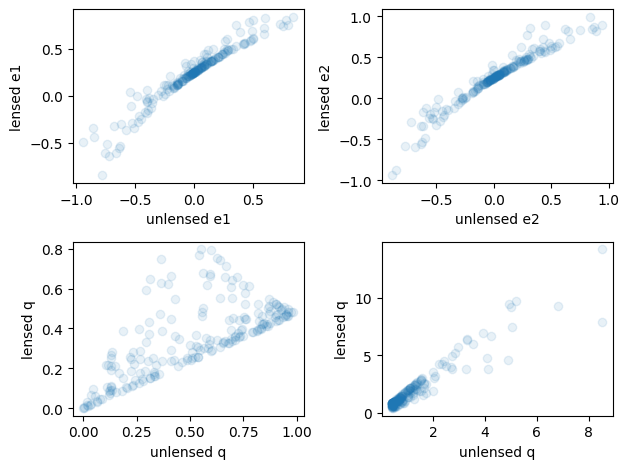

In [18]:
fig, ax = plt.subplots(2, 2)
_ = ax[0,0].scatter(galaxy_bulge_e1, galaxy_bulge_e1_lensed, alpha = 0.1)
_ = ax[0,0].set_xlabel('unlensed e1')
_ = ax[0,0].set_ylabel('lensed e1')
_ = ax[0,1].scatter(galaxy_bulge_e2, galaxy_bulge_e2_lensed, alpha = 0.1)
_ = ax[0,1].set_xlabel('unlensed e2')
_ = ax[0,1].set_ylabel('lensed e2')
_ = ax[1,0].scatter(tile_catalog['galaxy_bulge_q'], galaxy_bulge_q_lensed, alpha = 0.1)
_ = ax[1,0].set_xlabel('unlensed q')
_ = ax[1,0].set_ylabel('lensed q')
_ = ax[1,1].scatter(tile_catalog['galaxy_a_b'], galaxy_bulge_a_lensed, alpha = 0.1)
_ = ax[1,1].set_xlabel('unlensed q')
_ = ax[1,1].set_ylabel('lensed q')
fig.tight_layout()

We add $a_\ell$ and $q_\ell$ to the tile catalog for both the disk and the bulge:

In [19]:
tile_catalog['galaxy_a_d'] = galaxy_disk_a_lensed
tile_catalog['galaxy_a_b'] = galaxy_bulge_a_lensed
tile_catalog['galaxy_disk_q'] = galaxy_disk_q_lensed
tile_catalog['galaxy_bulge_q'] = galaxy_bulge_q_lensed

In [20]:
with initialize(config_path="../../", version_base=None):
    cfg = compose("lensing_config",
                  overrides = {"prior.batch_size=1",
                               "prior.n_tiles_h=1",
                               "prior.n_tiles_w=1",
                               "prior.max_sources=200",
                               "prior.constant_shear=0.2",
                               "prior.constant_convergence=0.2",
                               "generate.tiles_to_crop=0",
                               "decoder._target_=bliss.simulator.decoder.Decoder",
                               "decoder.tile_slen=256",
                               "decoder.use_survey_background=false",
                               "decoder.with_dither=false",
                               "decoder.with_noise=false"})

decoder = instantiate(cfg.decoder)

In [21]:
image2, psf_params = decoder.render_images(tile_catalog)

ttc = cfg.generate.tiles_to_crop
ptc = ttc * decoder.tile_slen  # pixels to crop
if ptc > 0:
    image2 = image2[:, :, ptc:-ptc, ptc:-ptc]

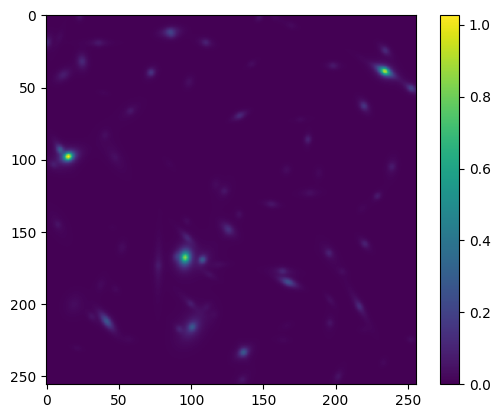

In [22]:
band = 2
_ = plt.imshow((image2[0,band] - image2[0,band].min() + 1).log())
_ = plt.colorbar()

---

We compare the pixel intensities of the two images produced using the two lensing methods (`GalSim.lens()` on the x-axis vs manual lensing on the y-axis). It appears that our manual approach does not exactly match `GalSim.lens()`.

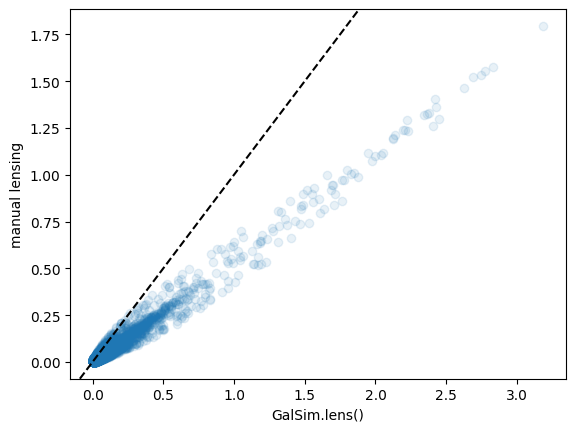

In [23]:
band = 2
_ = plt.scatter(image1[0,band].flatten(), image2[0,band].flatten(), alpha = 0.1)
_ = plt.xlabel('GalSim.lens()')
_ = plt.ylabel('manual lensing')
_ = plt.axline((0,0), slope = 1, color = 'black', linestyle = '--')